In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadr
import os
import numpy as np
from scipy.stats import chi2_contingency
from IPython.display import display, HTML


In [9]:
# Charger les fichiers CSV
df_freMTPL = pd.read_csv("/home/onyxia/work/Federated_Learning_Milliman/data/french_data.csv")
df_freMTPL

ParserError: Error tokenizing data. C error: Expected 12 fields in line 1133814, saw 13


/tmp/ipykernel_98780/157607161.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=["blue", "red"])


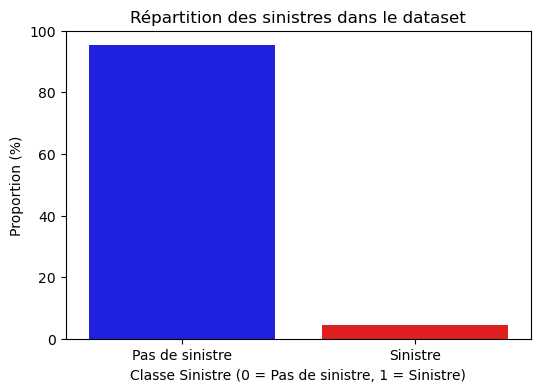

In [3]:
# Calcul de la proportion des sinistres
class_distribution = df_freMTPL["Sinistre"].value_counts(normalize=True) * 100

# Visualisation avec un graphique
plt.figure(figsize=(6, 4))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette=["blue", "red"])
plt.xlabel("Classe Sinistre (0 = Pas de sinistre, 1 = Sinistre)")
plt.ylabel("Proportion (%)")
plt.title("Répartition des sinistres dans le dataset")
plt.xticks([0, 1], ["Pas de sinistre", "Sinistre"])
plt.ylim(0, 100)
plt.show()


La classe 0 (Sinistre) est largement majoritaire. Dans ce genre de situation, l'accuracy n'est pas une métrique pertinente. D'autres métriques comme la précision, le rappel, ou la F-mesure sont souvent plus appropriées, car elles prennent en compte les performances du modèle sur les deux classes et non seulement sur la classe majoritaire.

## Correlation

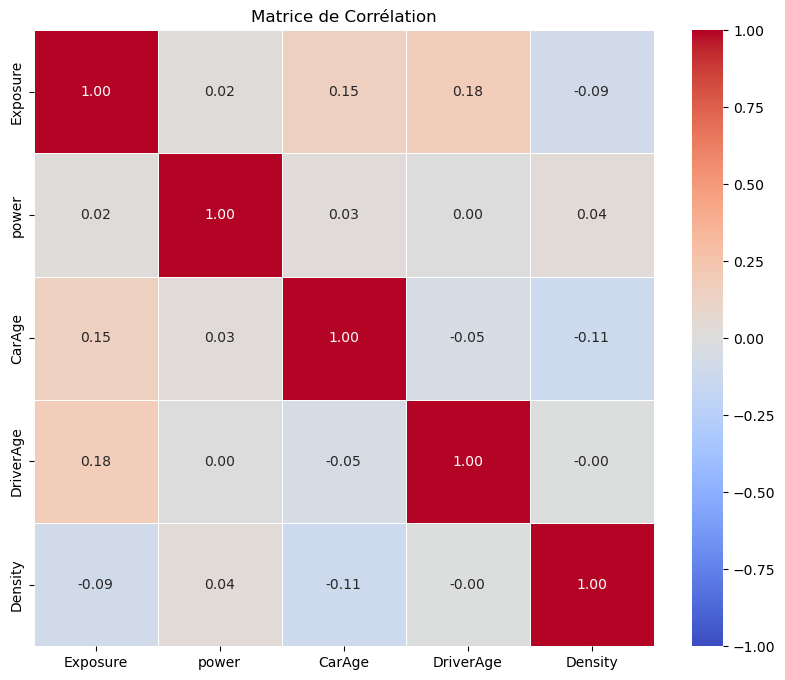

In [4]:

# Calcul de la matrice de corrélation pour les variables numériques
corr_matrix = df_freMTPL[['Exposure', 'power', 'CarAge', 'DriverAge', 'Density']].corr()

# Création de la carte de chaleur
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matrice de Corrélation')
plt.show()


In [5]:
def analyze_categorical_correlation(df_freMTPL, cat_vars=['CarBrand', 'CarGas', 'Region', 'Sex'], 
                                   alpha=0.05, figsize=(10, 8)):
   
    # Préparation des données
    cat_df = df_freMTPL[cat_vars].copy()
    for col in cat_df.select_dtypes(include='bool'):
        cat_df[col] = cat_df[col].astype(str)
    
    # Calcul des résultats
    results = []
    for i, var1 in enumerate(cat_vars[:-1]):
        for var2 in cat_vars[i+1:]:
            contingency_table = pd.crosstab(cat_df[var1], cat_df[var2])
            chi2, p, dof, _ = chi2_contingency(contingency_table)
            
            # Calcul du Cramer's V
            n = contingency_table.sum().sum()
            cramer_v = np.sqrt(chi2 / (n * min(contingency_table.shape[0]-1, contingency_table.shape[1]-1)))
            
            # Interprétation
            strength = "Très forte" if cramer_v >= 0.5 else \
                     "Forte" if cramer_v >= 0.3 else \
                     "Modérée" if cramer_v >= 0.1 else "Faible"
            
            results.append({
                'Paire de variables': f"{var1} - {var2}",
                'Cramer\'s V': cramer_v,
                'Force de la corrélation': strength,
                'p-value': p,
                'Significatif': p < alpha
            })
    
    # Création du DataFrame de résultats
    results_df = pd.DataFrame(results)
    
    # Style pour la visualisation
    def color_strength(val):
        color = 'white'
        if val == "Très forte": color = '#FF0000'  # Rouge
        elif val == "Forte": color = '#FF6666'     # Rouge clair
        elif val == "Modérée": color = '#FFCCCC'   # Rouge très clair
        return f'background-color: {color}'
    
    def color_pvalue(val):
        color = 'limegreen' if val < alpha else 'lightcoral'
        return f'color: {color}; font-weight: bold'
    
    # Application du style
    styled_df = results_df.style \
        .applymap(color_pvalue, subset=['p-value']) \
        .applymap(lambda x: 'background-color: limegreen' if x else 'background-color: lightcoral', 
                 subset=['Significatif']) \
        .applymap(color_strength, subset=['Force de la corrélation']) \
        .format({
            'Cramer\'s V': "{:.3f}",
            'p-value': "{:.4f}"
        }) \
        .set_caption("Résultats des tests de corrélation entre variables catégorielles") \
        .set_properties(**{
            'text-align': 'center',
            'font-size': '12pt',
            'border': '1px solid black'
        })
    
    # Affichage dans Jupyter
    display(styled_df)
    return results_df

results = analyze_categorical_correlation(df_freMTPL)

/tmp/ipykernel_98780/3466333591.py:50: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_pvalue, subset=['p-value']) \
/tmp/ipykernel_98780/3466333591.py:51: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'background-color: limegreen' if x else 'background-color: lightcoral',
/tmp/ipykernel_98780/3466333591.py:53: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(color_strength, subset=['Force de la corrélation']) \


,Paire de variables,Cramer's V,Force de la corrélation,p-value,Significatif
0,CarBrand - CarGas,0.111,Modérée,0.0000,True
1,CarBrand - Region,0.153,Modérée,0.0000,True
2,CarBrand - Sex,0.003,Faible,0.7448,False
3,CarGas - Region,0.093,Faible,0.0000,True
4,CarGas - Sex,0.000,Faible,0.6763,False
5,Region - Sex,0.004,Faible,0.7265,False


## Description des variables 

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def analyse_variable_numerique(df, var_num, cible='Sinistre'):
    print(f"## Analyse de la variable numérique : {var_num}\n")
    
    # Stat descriptives globales et par classe
    display(df[[var_num]].describe())
    display(df.groupby(cible)[var_num].describe())

    # Boxplot par classe
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')
    plt.title(f'{var_num} selon {cible}')
    plt.grid(True)
    plt.show()

    # Distribution (histogramme/kde)
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df, x=var_num, hue=cible, common_norm=False, fill=True)
    plt.title(f'Distribution de {var_num} selon {cible}')
    plt.grid(True)
    plt.show()

In [7]:
def analyse_variable_categorielle(df, var_cat, cible='Sinistre'):
    print(f"## Analyse de la variable catégorielle : {var_cat}\n")
    
    # Calcul du taux de sinistre + nombre d'observations + sinistres
    stats = df.groupby(var_cat).agg(
        Effectif=(cible, 'count'),
        Nombre_sinistres=(cible, 'sum'),
        Taux_de_sinistre=(cible, 'mean')
    ).sort_values(by='Taux_de_sinistre', ascending=False).reset_index()

    # Affichage stylisé
    display(stats.style
            .format({'Taux_de_sinistre': '{:.2%}'})
            .background_gradient(cmap='Reds', subset=['Taux_de_sinistre'])
            .set_caption(f"Taux de sinistre par '{var_cat}'"))

    # Diagramme en barres verticales
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(data=df, x=var_cat, hue=cible, palette='Set2')
    plt.title(f'Distribution de {var_cat} selon {cible}')
    plt.xticks(rotation=90)  # Modalités affichées verticalement
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


## Analyse de la variable numérique : Exposure



,Exposure
count,1.091182e+06
mean,5.409946e-01
std,3.666920e-01
min,2.732240e-03
25%,1.900000e-01
50%,5.000000e-01
75%,1.000000e+00
max,2.010000e+00


,count,mean,std,min,25%,50%,75%,max
Sinistre,,,,,,,,
0,1041732.0,0.535217,0.367129,0.002732,0.18,0.50,1.0,2.01
1,49450.0,0.662713,0.334944,0.002732,0.38,0.74,1.0,2.00


/tmp/ipykernel_98780/1896126319.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


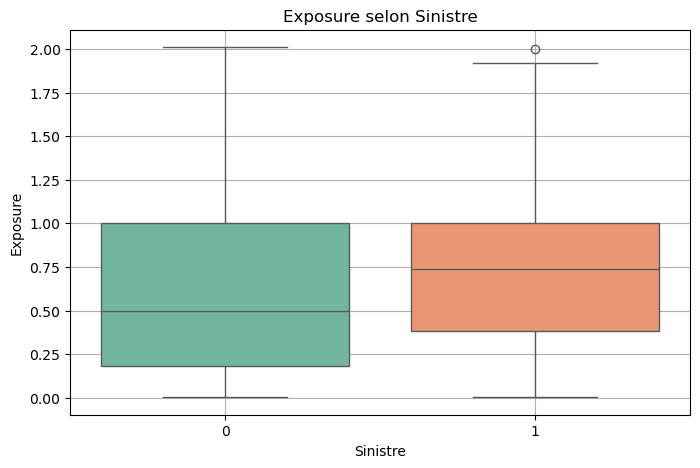

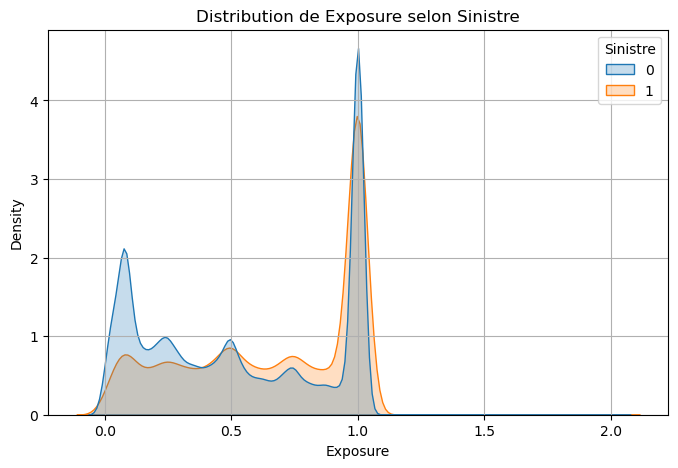

## Analyse de la variable numérique : power



,power
count,1.091182e+06
mean,1.808628e+01
std,1.780910e+01
min,4.000000e+00
25%,6.000000e+00
50%,8.000000e+00
75%,3.000000e+01
max,1.200000e+02


,count,mean,std,min,25%,50%,75%,max
Sinistre,,,,,,,,
0,1041732.0,18.178955,17.849789,4.0,6.0,8.0,30.0,120.0
1,49450.0,16.133893,16.811063,4.0,6.0,7.0,30.0,120.0


/tmp/ipykernel_98780/1896126319.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


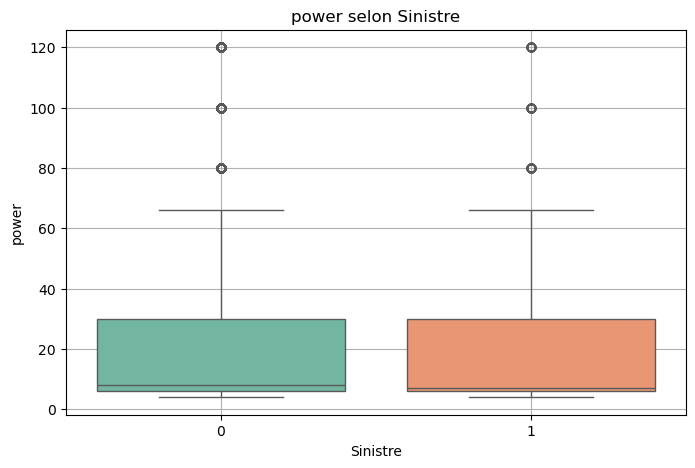

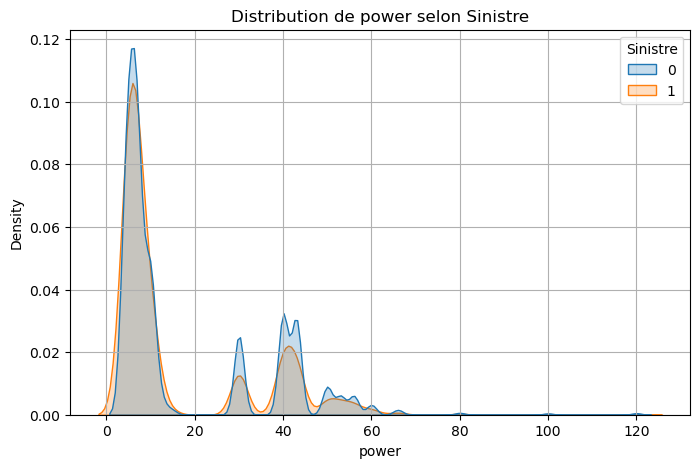

## Analyse de la variable numérique : CarAge



,CarAge
count,1.091182e+06
mean,7.229096e+00
std,5.707980e+00
min,0.000000e+00
25%,2.000000e+00
50%,6.000000e+00
75%,1.100000e+01
max,1.000000e+02


,count,mean,std,min,25%,50%,75%,max
Sinistre,,,,,,,,
0,1041732.0,7.245884,5.724000,0.0,2.0,6.0,11.0,100.0
1,49450.0,6.875430,5.347192,0.0,2.0,6.0,11.0,99.0


/tmp/ipykernel_98780/1896126319.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


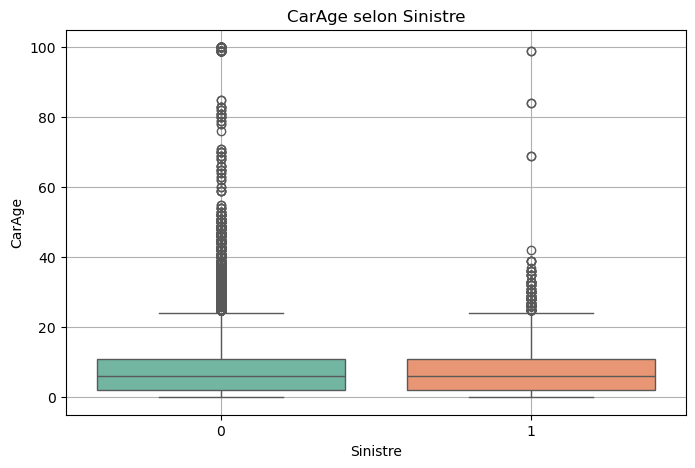

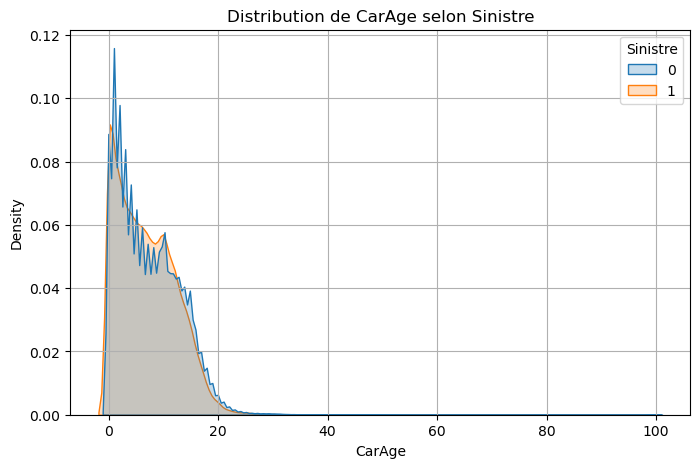

## Analyse de la variable numérique : DriverAge



,DriverAge
count,1.091182e+06
mean,4.543125e+01
std,1.421020e+01
min,1.800000e+01
25%,3.400000e+01
50%,4.400000e+01
75%,5.500000e+01
max,1.000000e+02


,count,mean,std,min,25%,50%,75%,max
Sinistre,,,,,,,,
0,1041732.0,45.412477,14.178441,18.0,34.0,44.0,55.0,100.0
1,49450.0,45.826775,14.858180,18.0,34.0,45.0,55.0,99.0


/tmp/ipykernel_98780/1896126319.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


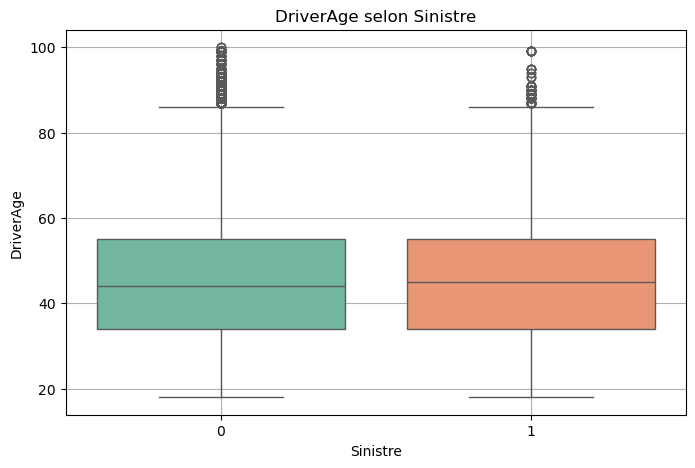

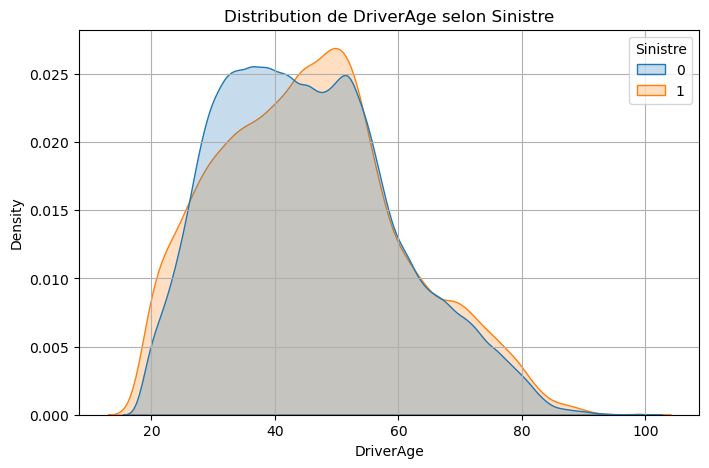

## Analyse de la variable numérique : Density



,Density
count,1.091182e+06
mean,1.865399e+03
std,4.287630e+03
min,1.000000e+00
25%,8.300000e+01
50%,3.540000e+02
75%,1.565000e+03
max,2.700000e+04


,count,mean,std,min,25%,50%,75%,max
Sinistre,,,,,,,,
0,1041732.0,1859.185769,4278.858397,1.0,83.0,348.0,1541.0,27000.0
1,49450.0,1996.287947,4466.452890,2.0,94.0,405.0,1842.0,27000.0


/tmp/ipykernel_98780/1896126319.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cible, y=var_num, data=df, palette='Set2')


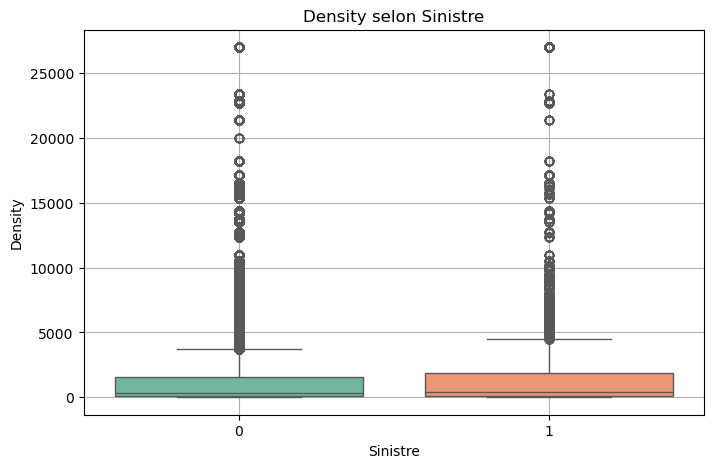

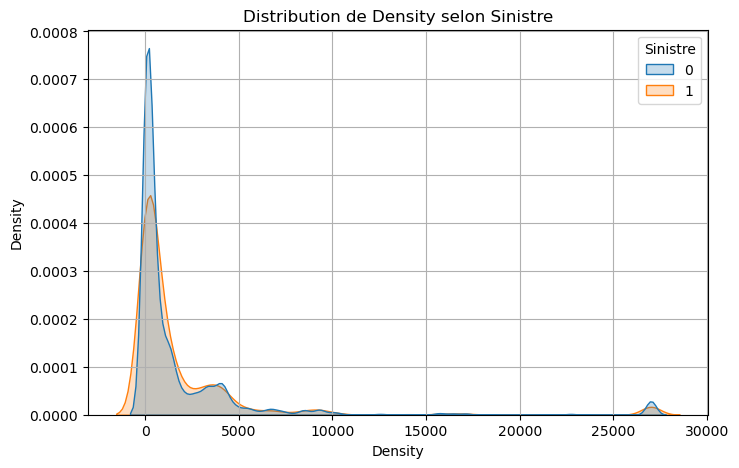

## Analyse de la variable catégorielle : CarBrand



,CarBrand,Effectif,Nombre_sinistres,Taux_de_sinistre
0,B5,34753,1915,5.51%
1,B2,159861,8128,5.08%
2,B13,12178,613,5.03%
3,B1,162736,8177,5.02%
4,B11,13585,681,5.01%
5,B3,53395,2671,5.00%
6,B4,25179,1254,4.98%
7,B12,166024,8256,4.97%
8,B6,28548,1388,4.86%
9,B10,17707,817,4.61%


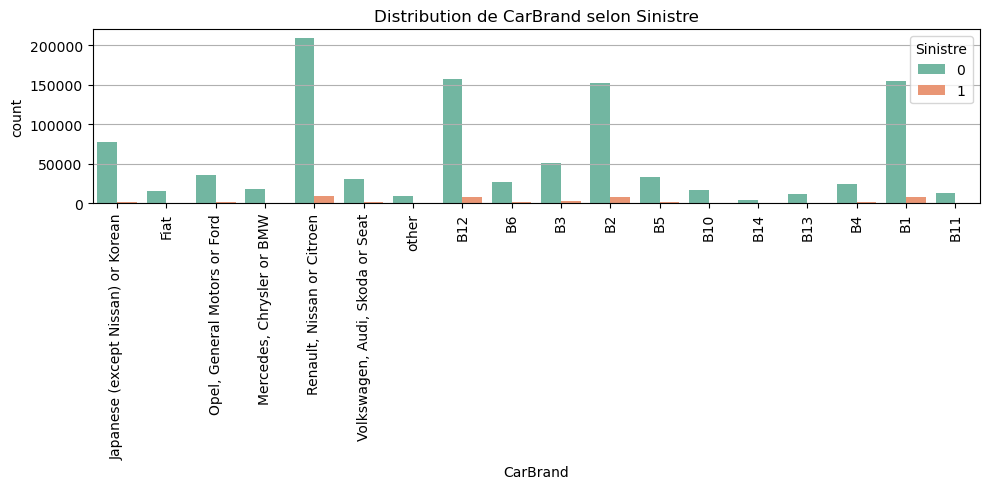

## Analyse de la variable catégorielle : CarGas



,CarGas,Effectif,Nombre_sinistres,Taux_de_sinistre
0,Regular,553101,25700,4.65%
1,Diesel,538081,23750,4.41%


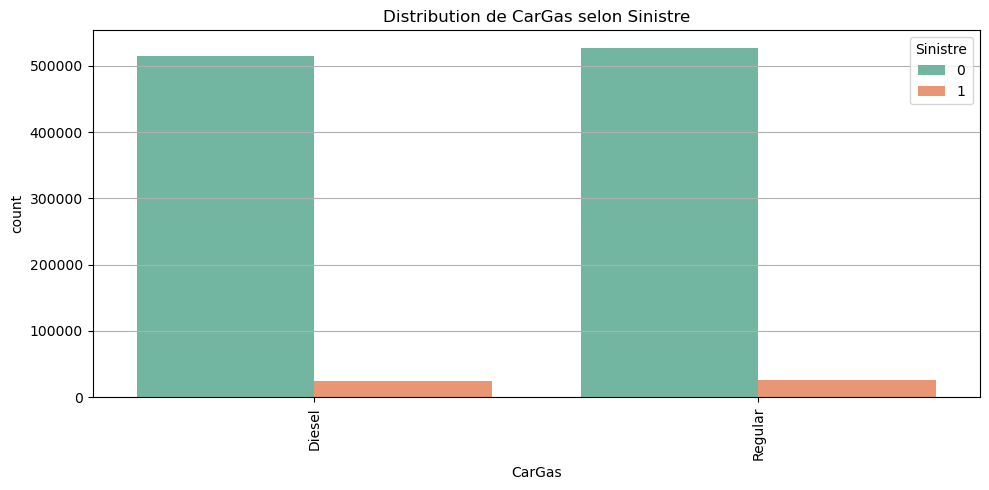

## Analyse de la variable catégorielle : Region



,Region,Effectif,Nombre_sinistres,Taux_de_sinistre
0,Alsace,2200,124,5.64%
1,Rhone-Alpes,84752,4760,5.62%
2,Picardie,7994,421,5.27%
3,Bretagne,84244,4368,5.18%
4,Champagne-Ardenne,3026,149,4.92%
5,Corse,4516,220,4.87%
6,Basse-Normandie,21786,1034,4.75%
7,Centre,321202,15070,4.69%
8,Limousin,9134,426,4.66%
9,Bourgogne,10492,488,4.65%


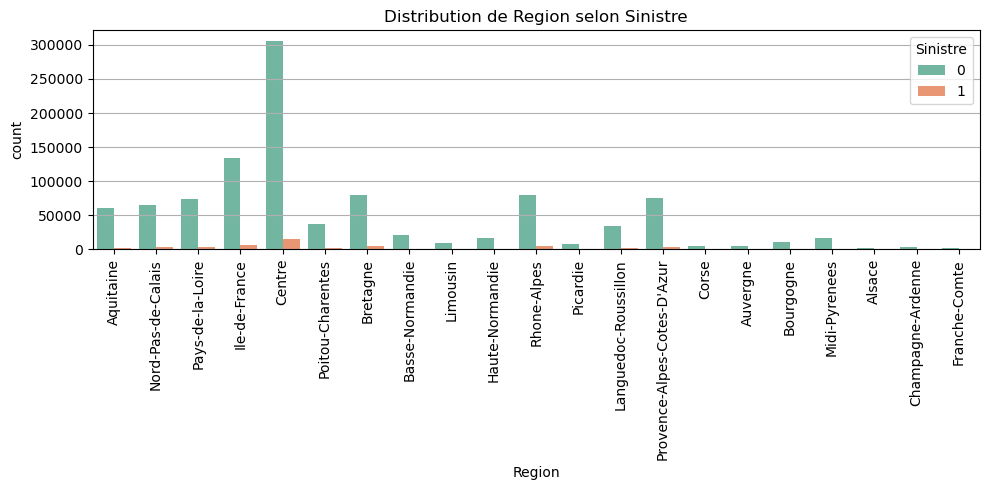

## Analyse de la variable catégorielle : Sex



,Sex,Effectif,Nombre_sinistres,Taux_de_sinistre
0,1,654956,29853,4.56%
1,0,436226,19597,4.49%


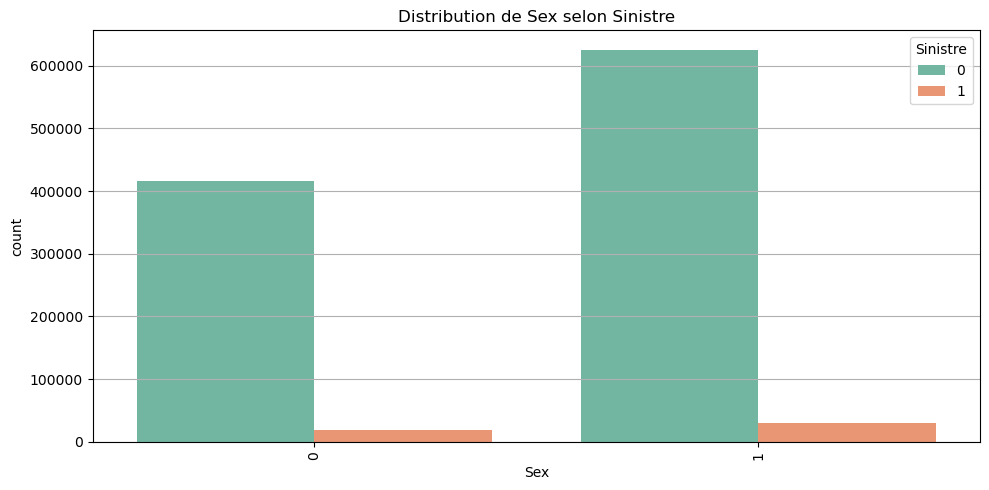

In [8]:
# Liste des variables
vars_num = ['Exposure', 'power', 'CarAge', 'DriverAge', 'Density']
vars_cat = ['CarBrand', 'CarGas', 'Region', 'Sex']

# Analyse automatique
for var in vars_num:
    analyse_variable_numerique(df_freMTPL, var)

for var in vars_cat:
    analyse_variable_categorielle(df_freMTPL, var)
